Here we will try to use technic Augmentation of data with combination of transfer learning

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

resolution = (256, 256)

#predprocess data 
directory = 'datasets'

train = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="training",

)

valid = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="validation",

)


Found 11302 files belonging to 8 classes.
Using 10172 files for training.
Found 11302 files belonging to 8 classes.
Using 1130 files for validation.


In [25]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)



In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [27]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = resolution + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [29]:
input_shape = tf.keras.Input(shape=(resolution[0],resolution[1], 3))
x = data_augmentation(input_shape)

## we want to get resolution of dataset imgs as was in pre-trained model
x =  tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

## preventing overfitiing
x = tf.keras.layers.Dropout(0.2)(x)

## this is layer is added because we want to our dataset classes == pretrained model outputs
outputs_shape = tf.keras.layers.Dense(8)(x)
model = tf.keras.Model(input_shape, outputs_shape)

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
history = model.fit(train,
                    epochs=60,
                    validation_data=valid)

Epoch 1/60
318/318 [==============================] - 357s 1s/step - loss: 0.9890 - accuracy: 0.6668 - val_loss: 0.7445 - val_accuracy: 0.7487
Epoch 2/60
318/318 [==============================] - 352s 1s/step - loss: 0.6571 - accuracy: 0.7925 - val_loss: 0.6115 - val_accuracy: 0.8088
Epoch 3/60
318/318 [==============================] - 355s 1s/step - loss: 0.5414 - accuracy: 0.8349 - val_loss: 0.5127 - val_accuracy: 0.8522
Epoch 4/60
318/318 [==============================] - 352s 1s/step - loss: 0.4837 - accuracy: 0.8565 - val_loss: 0.4644 - val_accuracy: 0.8690
Epoch 5/60
318/318 [==============================] - 353s 1s/step - loss: 0.4340 - accuracy: 0.8751 - val_loss: 0.4296 - val_accuracy: 0.8903
Epoch 6/60
318/318 [==============================] - 348s 1s/step - loss: 0.4060 - accuracy: 0.8806 - val_loss: 0.4044 - val_accuracy: 0.8929
Epoch 7/60
318/318 [==============================] - 356s 1s/step - loss: 0.3892 - accuracy: 0.8847 - val_loss: 0.3835 - val_accuracy: 0.8982

In [32]:
model.save('model2.h5')

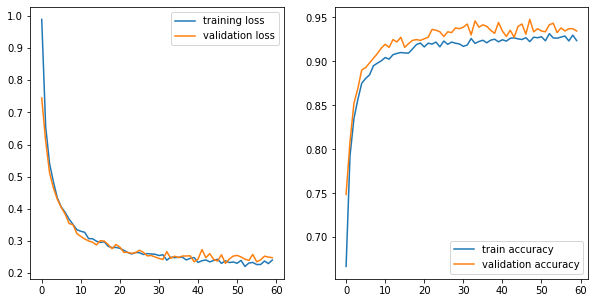

In [44]:
w = 10
h = 10
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

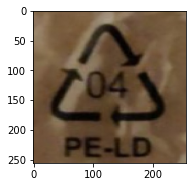

1/1 [==============================] - 0s 466ms/step
7 predicted


array([[ -7.291543  ,  -2.7108462 ,  -4.531022  , -11.252198  ,
         -2.0314147 ,  -4.579196  ,  -9.438374  ,   0.43057746]],
      dtype=float32)

In [35]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')




img = procces_img('test/Screenshot 2023-01-17 113435.jpg')
plot_img(img)
prediction = model.predict(img.reshape((-1, 256, 256, 3)))
print(f'{get_result(prediction)} predicted' )
prediction

In [45]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   